# Cycling Genes Detection (et al., Preston)

### Loading the required libraries

In [ ]:
library(GLMMcosinor)
library(tidyverse)
library(ggplot2)

### Loading the Counts Matrix

In [3]:
counts <- read.csv("gene_counts_preston.csv", sep = ",", header = TRUE)
annot <- read.csv("metadata_preston.csv", sep = ",", header = TRUE)

### Filtering the genes from the count matrix

In [4]:
row.names(counts) <- counts$X
counts <- counts[, -1]

fil_1 <- rowSums(counts > 10) >= 10

gene_var <- apply(counts, 1, var)
fil_2 <- gene_var > 20

gene_means <- rowMeans(counts)
fil_3 <- gene_means > 10

genes_fil <- row.names(counts)[fil_1 & fil_2 & fil_3]

counts_fil <- counts[genes_fil, ]

### Conversion of the Counts Matrix

In [5]:
counts_fil <- t(counts_fil)

count_data <- as.data.frame(counts_fil)
count_data$Sample <- row.names(count_data)

count_long <- count_data %>% pivot_longer(cols = -Sample, names_to = 'Gene', values_to = 'Expression')

final_count <- left_join(count_long, annot, by = 'Sample')

### GLMM Cosinor Function to delect Circadian Cycling Genes

In [6]:
run_cglmm <- function(gene, data) {
  df_gene <- data[data$Gene == gene, ]
  
  fit <- cglmm(Expression ~ amp_acro(Time, period = 24), data = df_gene, family = gaussian())
  coefs <- summary(fit)
  
  raw <- as.data.frame(coefs$raw.table)
  raw$Coefficient <- row.names(raw)
  raw$Type <- "Raw"

  transformed <- as.data.frame(coefs$transformed.table)
  transformed$Coefficient <- row.names(transformed)
  transformed$Type <- "Transformed"

  all_coefs <- bind_rows(raw, transformed) %>%
    relocate(Type, Coefficient) %>%
    mutate(Gene = gene)

  return(all_coefs)
}

### Running the GLMM Cosinor function to all the Filtered Genes

In [7]:
gene_list <- unique(final_count$Gene)

results_list <- lapply(gene_list, run_cglmm, data = final_count)
results_df <- do.call(rbind, results_list)

There were 50 or more warnings (use warnings() to see the first 50)


## Significantly Cycling Genes Detection

In [8]:
amp_val <- results_df %>% filter(Type == "Transformed", Coefficient == "amp1")

### Filtering Genes with p value < 0.05

In [14]:
sig_genes <- amp_val %>% filter(p.value < 0.05) %>% arrange(p.value)
head(sig_genes)

                 Type Coefficient    estimate standard.error    lower.CI
amp111497 Transformed        amp1   358.36948      89.165522   183.60827
amp114704 Transformed        amp1    23.31706       5.860217    11.83124
amp1667   Transformed        amp1 26922.53472    6993.377972 13215.76576
amp113737 Transformed        amp1    22.17445       5.870554    10.66837
amp17231  Transformed        amp1   741.71999     207.903432   334.23675
amp113943 Transformed        amp1    73.31004      21.394721    31.37716
             upper.CI      p.value    Gene
amp111497   533.13069 5.840884e-05   Bmal1
amp114704    34.80287 6.924283e-05 Gm48606
amp1667   40629.30367 1.182538e-04   Ndrg1
amp113737    33.68052 1.585809e-04 Gm16199
amp17231   1149.20323 3.602414e-04 Slc16a1
amp113943   115.24292 6.113055e-04  Gm2004

### Plotting the Rhythmic Curves of Cyclic Genes

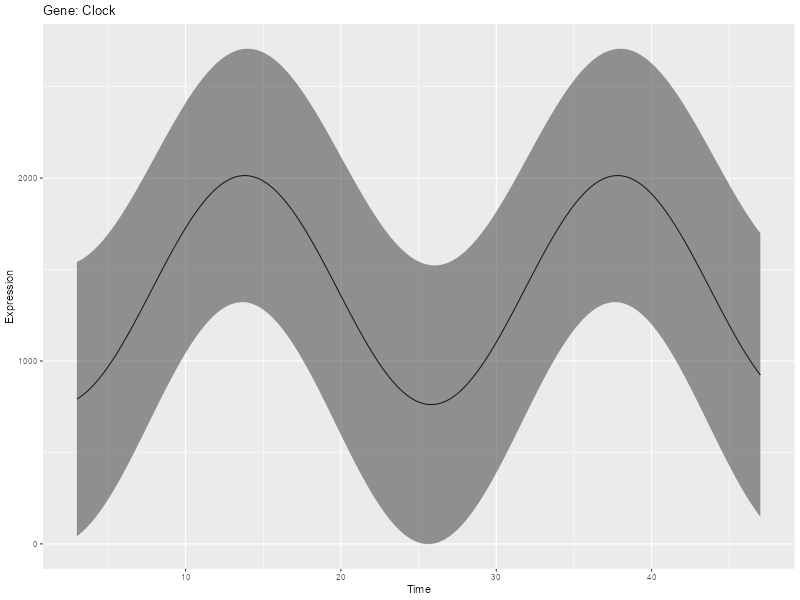

In [15]:
df_clock <- final_count[final_count$Gene == "Clock", ]
fit_clock <- cglmm(Expression ~ amp_acro(Time, period = 24), data = df_clock, family = gaussian())
print(autoplot(fit_clock) + ggtitle(paste("Gene: Clock")))

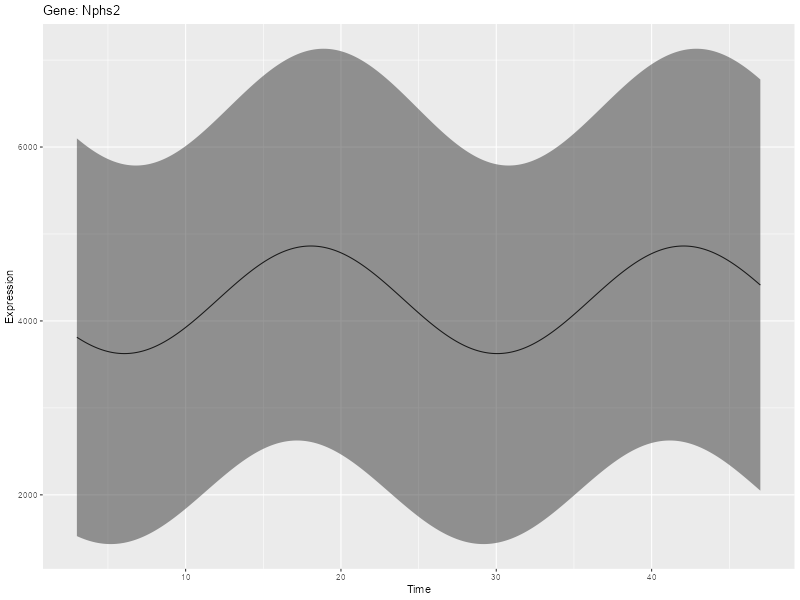

In [16]:
df_nphs2 <- final_count[final_count$Gene == "Nphs2", ]
fit_nphs2 <- cglmm(Expression ~ amp_acro(Time, period = 24), data = df_nphs2, family = gaussian())
print(autoplot(fit_nphs2) + ggtitle(paste("Gene: Nphs2")))

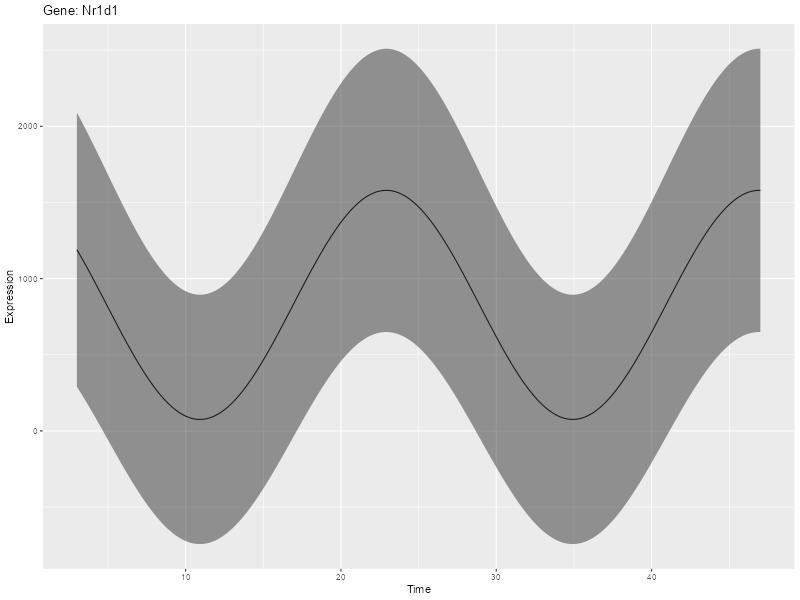

In [17]:
df_nr1d1 <- final_count[final_count$Gene == "Nr1d1", ]
fit_nr1d1 <- cglmm(Expression ~ amp_acro(Time, period = 24), data = df_nr1d1, family = gaussian())
print(autoplot(fit_nr1d1) + ggtitle(paste("Gene: Nr1d1")))

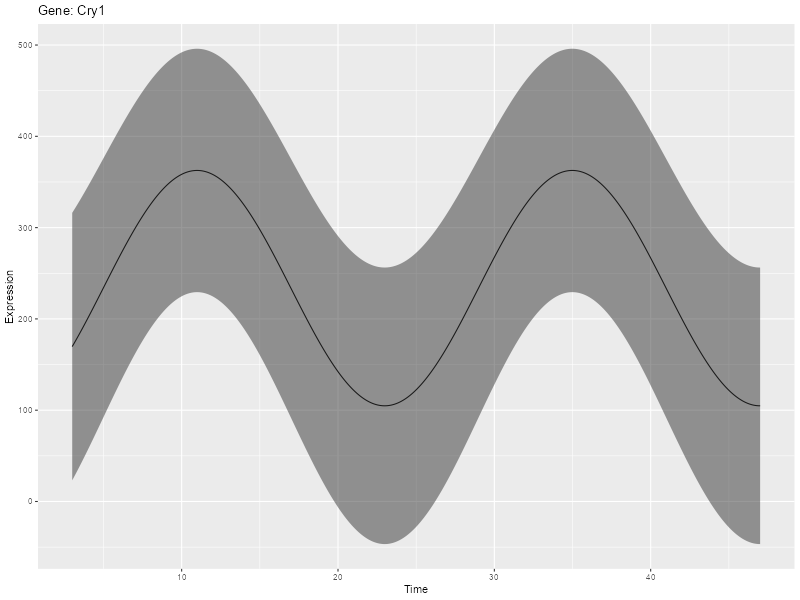

In [18]:
df_cry1 <- final_count[final_count$Gene == "Cry1", ]
fit_cry1 <- cglmm(Expression ~ amp_acro(Time, period = 24), data = df_cry1, family = gaussian())
print(autoplot(fit_cry1) + ggtitle(paste("Gene: Cry1")))

In [19]:
cyc_genes <- sig_genes$Gene

In [ ]:
write.csv(cyc_genes, "Circardian_Cycling_Genes.csv")